# EVALUATION NOTEBOOK

#### Study on the effect of Prefilters
The dataset was transcribed with two different prefilters.
paired differences of the f-scores are shown as violinplot and boxplots

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import librosa
import utils
import dataloader
import features

dataset = dataloader.Dataloader("beatles",base_path="mirdata",source_separation="none")
audiopath,gtpath = dataset["1201"] # 0108 love me do, 1201 two of us
y = utils.loadAudiofile(audiopath)
gt = utils.loadChordAnnotations(gtpath)
# compute chromagram
chroma, pitchgram,pitchgram_cqt = features.crpChroma(y,nCRP=33,eta=100,liftering=True,window=False)
t_chroma = utils.timeVector(N=chroma.shape[1],hop_length=2048)


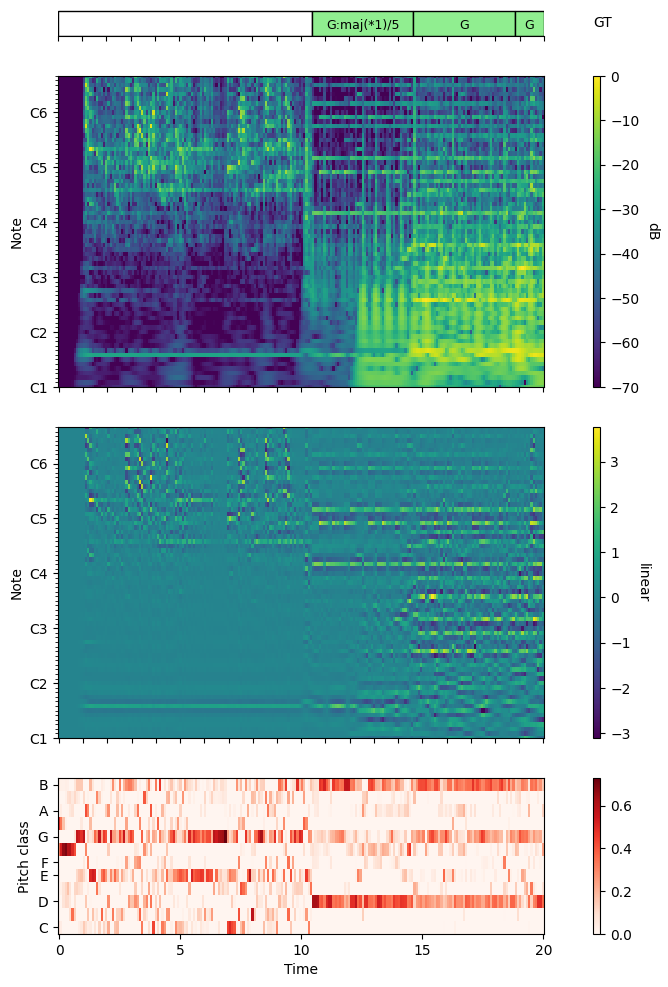

In [11]:
## Plot Pitchgram, liftered pitchgram and CRP 
time_interval = (0,20)
fig,((ax1,ax11),(ax2,ax21),(ax3,ax31),(ax4,ax41)) = plt.subplots(4,2,height_ratios=(.5,6,6,3),
                                                                 width_ratios=(20,.3),figsize=(7,12))
utils.plotChordAnnotations(ax1,gt[0],gt[1],time_interval=time_interval,y_0=0)
ax11.text(0,0.5,"GT")
ax1.set_ylim(0,1.5)
ax11.set_ylim(0,1.5)
ax1.set_yticks([])
# Hide the y-axis line
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.axis("on")
ax11.set_axis_off()
i0,i1 = utils.getTimeIndices(t_chroma,time_interval)
img = librosa.display.specshow(librosa.amplitude_to_db(pitchgram_cqt[:,i0:i1],ref=np.max(pitchgram_cqt[:,i0:i1])),
                            x_coords=t_chroma[i0:i1],
                            x_axis="time",
                            y_axis='cqt_note',
                            cmap="viridis",
                            fmin=librosa.midi_to_hz(24),
                            fmax=librosa.midi_to_hz(84),
                            bins_per_octave=12,
                            ax=ax2,
                            vmin=-70,
                            vmax=0)
cbar = fig.colorbar(img,cax=ax21)
cbar.ax.set_ylabel("dB", rotation=-90, va="bottom")
img = librosa.display.specshow(pitchgram[:,i0:i1],
                            x_coords=t_chroma[i0:i1],
                            x_axis="time",
                            y_axis='cqt_note',
                            cmap="viridis",
                            fmin=librosa.midi_to_hz(24),
                            fmax=librosa.midi_to_hz(84),
                            bins_per_octave=12,
                            ax=ax3)
ax2.set_ylim(librosa.midi_to_hz(24),librosa.midi_to_hz(92))
ax3.set_ylim(librosa.midi_to_hz(24),librosa.midi_to_hz(92))
cbar = fig.colorbar(img,cax=ax31)
cbar.ax.set_ylabel("linear", rotation=-90, va="bottom")
xticks = np.linspace(time_interval[0],time_interval[1],21)
xticklabels = [xticks[i] if i % 5 == 0 else "" for i in range(21)]
for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticks(xticks)
    ax.set_xlabel("")
    ax.set_xticklabels([])
ax4.set_xticklabels(xticklabels)
ax4.set_xlabel("Time in s")

img = utils.plotChromagram(ax4,t_chroma,chroma,time_interval=time_interval)
fig.colorbar(img,cax=ax41);

fig.savefig("../latex/figures/example_two_of_us.png")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import utils

def printRow(data,prefilter="RP",alphabet="majmin"):
    text = f"{prefilter} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)


print(f"----------Table of results------------")
rp_text = "RP &"
median_text = "Median &"
header = "prefilter & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    rp, track_list = utils.getFscoreResults("../results/prefilter_rp.hdf5",alphabet,True)
    median,_ = utils.getFscoreResults("../results/prefilter_median.hdf5",alphabet, True)
    printRow(rp,"RP",alphabet)
    printRow(median,"Median",alphabet)
    print("\\midrule")

    # plot paired difference
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        deltas.append([100*(x-y) for x,y in zip(rp[dset],median[dset])])

    # print outliers
    print("-------outliers---------")
    for x,name in zip(deltas[-1],track_list):
        if np.abs(x) > 10:
            print(f"{name} : {x}%")
        
     # plot sorted results
    index = np.argsort(median["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(100*np.array(median["combined"])[index],'k')
    ax.plot(100*np.array(rp["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["Median","RP"],loc='lower right')
    fig.savefig(f"../latex/figures/prefilter_sorted_{alphabet}.png")
        
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    # fig.savefig(f"../latex/figures/prefilter_delta_f_{alphabet}.png")
    ax.set_ylabel("delta F-score in %")
    # wilcoxon test
    print("-----Wilcoxon test for paired samples SEVENTHS-------")
    print("dataset & N & z & p & r \\\\")
    print("\\toprule")
    for i,dset in enumerate(["beatles","rwc\_pop","rw","queen","combined"]):
        N,p,z,r = utils.wilcoxonTest(deltas[i])
        if p < 0.001:
            print(f"{dset} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
        else:    
            print(f"{dset} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")


#### Study on Source Separation
Vocals, drums were removed seperately with a hybrid transformer source separation network (demucs) to enhance the chroma.</br>
After seperating the drums, the vocals were again removed from the remaining signal. F-scores for three source separation scenarios were computed (vocals removed, drums removed, vocals and drums removed)



In [ ]:
import h5py

def getFscoreResults(filepath,alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printHeader():
    print(f"----------Table of results------------")
    header = "separation & scheme &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        if dset == "rwc_pop":
            header += "rwc\_pop & "
        else:
            header += dset +" &"
    header = header[:-1] + "\\\\"
    print(header)

def printRowFscore(data,method="none",alphabet="majmin"):
    text = f"{method} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.2f}$\\pm${iqr:0.2f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def printRowTtest(data,pair="none"):
    res = scipy.stats.wilcoxon(data,method='approx')
    N = len(data)
    p = res.pvalue
    z = res.zstatistic
    r = np.abs(z) / np.sqrt(N)
    if p < 0.001:
        print(f"{dset} & {pair} & {N} & {z:0.1f} & $<$.001 & {r:0.1f}\\\\")
    else:    
        print(f"{dset} & {pair} & {N} & {z:0.1f} & {p:0.3f} & {r:0.1f}\\\\")

printHeader()
data = {}
for separation in ["none","vocals","drums","both"]:
    data[separation] = getFscoreResults(f"../results/source_separation_{separation}","majmin",False)
    printRowFscore(data[separation][0],method=separation,alphabet="majmin")

# check if the f-score results are in correct order for all files
for a,b,c,d in zip(data["none"][1],data["vocals"][1],data["drums"][1],data["both"][1]):
    if a != b or b != c or c != d or a != d:
        raise ValueError("filenames don't match!")

print("--------comparison pairs for wilcoxon test----")
# mix,vocals - mix,drums - mix, vocals/drums
row = "Comparison Pair"
for sep in ["vocals","drums","both"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[sep][0][dset],data["none"][0][dset])]
        printRowTtest(delta,f"none, {sep}")
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    # fig.savefig(f"../latex/figures/separation_{sep}_delta_majmin.png")


#### Study on correlation vs inner product

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import utils

def printRow(data,mof="inner",alphabet="majmin"):
    text = f"{mof} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

def getResults(filepath,alphabet="majmin",printMetadata=False):
    results_corr = {"combined":[]}
    results_inner = {"combined":[]}
    results_deltas = {"combined":[]} # correlation - innerproduct
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores_corr = []
            f_scores_inner_product = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    f_scores_corr.append(100 * subgrp.attrs.get(f"{alphabet}_f_correlation"))
                    f_scores_inner_product.append(100 * subgrp.attrs.get(f"{alphabet}_f_inner_product"))
            results_corr[dset] = f_scores_corr
            results_inner[dset] = f_scores_inner_product
            results_deltas[dset] = [x-y for x,y in zip(f_scores_corr,f_scores_inner_product)]
            results_corr["combined"] += f_scores_corr
            results_inner["combined"] += f_scores_inner_product
            results_deltas["combined"] += results_deltas[dset]
    return results_corr,results_inner,results_deltas,track_list

colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
text = "Median &"
header = "distance & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    results_corr,results_inner,results_deltas,track_list = getResults("../results/distance_measure.hdf5",alphabet,False)
    printRow(results_corr,"correlation",alphabet)
    printRow(results_inner,"inner product",alphabet)
    print("\\midrule")

    # plot sorted results
    index = np.argsort(results_inner["combined"])    
    fig,ax = plt.subplots(figsize=(6,2))
    ax.plot(np.array(results_inner["combined"])[index],'k')
    ax.plot(np.array(results_corr["combined"])[index])
    ax.grid()
    ax.set_ylabel("F-score in %")
    ax.set_xlim(0,349)
    ax.set_xlabel("Track number")
    ax.set_ylim(0,100)
    ax.legend(["inner","corr"])
    # fig.savefig(f"../latex/figures/corr_sorted_{alphabet}.png")

    # plot deltas
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,[x for x in results_deltas.values()],xlabels)
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/corr_delta_{alphabet}.png")

    print(f"Wilcoxon Test: combined dataset {alphabet}")
    (N,p,z,r) = utils.wilcoxonTest(results_deltas["combined"])
    if p < 0.001:
        print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
    else:    
        print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")

#### Comparison of Chord Models

In [ ]:
import matplotlib.pyplot as plt
import h5py
import utils
# est_cpss_majmin_f, stable_cpss_majmin_f
# est_templates_majmin_f, stable_templates_majmin_f

def getFscoreResults(filepath, model, alphabet, printMetadata=True):
    results = {"combined":[]}
    track_list = []
    with h5py.File(filepath,"r") as file:
        text = "----Transcription Metadata----\n"
        for key,value in file.attrs.items():
            text += f"{key}={value}\n"
        if printMetadata:
            print(text)
        
        for dset in ["beatles","rwc_pop","rw","queen"]:
            f_scores = []
            for subgrp_name in file[f"{dset}/"]:
                subgrp = file[f"{dset}/{subgrp_name}"]
                if subgrp.attrs.get("name") not in utils.OUTLIERS:
                    track_list.append(subgrp.attrs.get("name"))
                    if file.attrs.get("experiment") == "pitchspace_crp": 
                        f = subgrp.attrs.get(f"{alphabet}_f_{model}")
                    else:
                        f = subgrp.attrs.get(f"{model}_{alphabet}_f")
                    if f is None: # deep chroma estimation is stored in different format!
                        f = subgrp.attrs.get(f"{alphabet}_f")
                    f_scores.append(100 * f)
            results[dset] = f_scores
            results["combined"] += f_scores
    return results,track_list

def printRow(data,model="inner",alphabet="majmin"):
    text = f"{model} & {alphabet} &"
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        med,iqr = utils.computeStatistics(data[dset])
        text += f"{med:0.1f}$\\pm${iqr:0.1f} &"
    text = text[:-1]+ "\\\\"
    print(text)

# Comparison of Template and CPSS model with the CRP feature
data = {}
# load transcription results for total transcription, and for stable chroma regions
for model in ["cpss","templates","stableregions_cpss","stableregions_templates"]:
    for alphabet in ["majmin","sevenths"]:
        data[f"{model}_{alphabet}"] = getFscoreResults("../results/crp_pitchspace.hdf5",model,alphabet,False)
print(f"----------Table of results------------")
header = "model & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    printRow(data[f"templates_{alphabet}"][0],"Templates",alphabet)
    printRow(data[f"cpss_{alphabet}"][0],"CPSS",alphabet)
    print("\\midrule")
print("----------------------------")

# plot deltas in stable regions
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"stableregions_cpss_{alphabet}"][0][dset],
                                    data[f"stableregions_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(delta)
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/crp_delta_stableregions_{alphabet}.png")
    plt.close()

    
# difference of models
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"cpss_{alphabet}"][0][dset],
                                    data[f"templates_{alphabet}"][0][dset])]
        deltas.append(delta)
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(delta)
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")
    fig,ax = plt.subplots(figsize=(6,2))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/crp_delta_{alphabet}.png")
    plt.close()

In [ ]:
data = {}
# load transcription results for total transcription, and for stable chroma regions
for model in ["est_cpss","est_templates","stable_cpss","stable_templates"]:
    for alphabet in ["majmin","sevenths"]:
        data[f"{model}_{alphabet}"] = getFscoreResults("../results/dcp_pitchspace.hdf5",model,alphabet,False)

# load transcription results with deep chroma processor
for alphabet in ["majmin","sevenths"]:
    data[f"est_dcp_{alphabet}"] = getFscoreResults("../results/dcp_madmom.hdf5",model,alphabet,False)

# check if the f-score results are in correct order for both files!
for a,b in zip(data["est_dcp_majmin"][1],data["est_cpss_majmin"][1]):
    if a != b:
        raise ValueError("filenames don't match!")

# plot table of Transcription results
colors = ['r','g','b','purple']
xlabels = ["Beatles","RWC","RW","Queen","Combined"]
print(f"----------Table of results------------")
header = "model & scheme &"
for dset in ["beatles","rwc_pop","rw","queen","combined"]:
    if dset == "rwc_pop":
        header += "rwc\_pop & "
    else:
        header += dset +" &"
header = header[:-1] + "\\\\"
print(header)
for alphabet in ["majmin","sevenths"]:
    printRow(data[f"est_dcp_{alphabet}"][0],"DCP",alphabet)
    printRow(data[f"est_templates_{alphabet}"][0],"Templates",alphabet)
    printRow(data[f"est_cpss_{alphabet}"][0],"CPSS",alphabet)
    print("\\midrule")
print("----------------------------")
# plot deltas in stable regions
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"stable_cpss_{alphabet}"][0][dset],
                                    data[f"stable_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
        if dset == "combined":
            print(f"Wilcoxon Test stable regions: combined dataset {alphabet}")
            (N,p,z,r) = utils.wilcoxonTest(results_deltas["combined"])
            if p < 0.001:
                print(f"N={N} z={z:0.1f} p=$<$.001  r={r:0.2f}\\\\")
            else:    
                print(f"N={N} z={z:0.1f} p={p:0.3f} r={r:0.2f}\\\\")
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/stable_regions_{alphabet}.png")

# pairwise comparison of models
    
# CPSS vs Templates
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_cpss_{alphabet}"][0][dset],
                                    data[f"est_templates_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_cpss_templates_{alphabet}.png")
    plt.close()

# Templates vs DCP
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_templates_{alphabet}"][0][dset],
                                    data[f"est_dcp_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_templates_dcp_{alphabet}.png")
    plt.close()

# CPSS vs DCP
for alphabet in ["majmin","sevenths"]:
    deltas = []
    for dset in ["beatles","rwc_pop","rw","queen","combined"]:
        delta = [x-y for x,y in zip(data[f"est_cpss_{alphabet}"][0][dset],
                                    data[f"est_dcp_{alphabet}"][0][dset])]
        deltas.append(delta)
    fig,ax = plt.subplots(figsize=(6,2.5))
    utils.create_violinplot(ax,deltas,["Beatles","RWC","RW","Queen","Combined"])
    ax.set_ylabel("delta F-score in %")
    # fig.savefig(f"../latex/figures/comparison_cpss_dcp_{alphabet}.png")



#### Visualization Tool

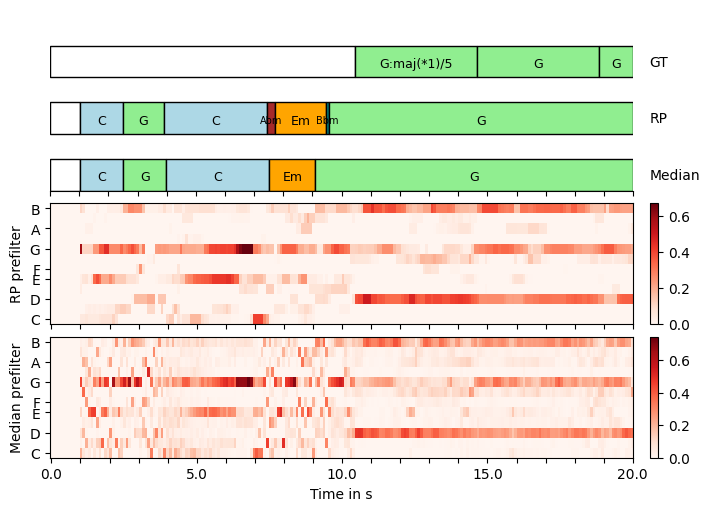

In [24]:
from visualization import visualizationApp
import matplotlib.pyplot as plt
%matplotlib inline
visualizationApp("../results")
plt.ioff();